# UDACITY CAPSTONE PROJECT
# For the Award of an Advanced Data Science Nanodegree.


## BY SUCCES DONALD  ATTONI

## PROJECT TITLE: Dog Breed Clasifier Using CNN.


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.


---
<font  style = "color:blue"><b><em>Important!</em></b> This notebook has been modified as I see fit to enable me address some of the challenges I encountered in completing the project. 

For example, I have used pytorch instead of tensorflow due to the challenges I encounted in setting up tensorflow. 
Even after I managed to set up tensorflow, I ran into many issues with developing the and using the classfier. One of the major challenges was erros ecountered in running from the line:
    
    "keras.applications.resnet50 import ResNet50, preprocess_input" in the "extract_bottlenect_features.py". 

This line generates the `error: ImportError: No module named applications`. 
In all my reserarch, I was unable to find a fix that didn't have other issues
</font>


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm


---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cells below, we import the dataset of dog and human images and store them in the human_files and dog_files respectively.

In [1]:
# Import required packages

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

import time
import os

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # Set PIL to be tolerant of image files that are truncated.


import face_recognition

import cv2

import torch
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim


from random import randint
from random import seed

from tqdm import tqdm

In [2]:
import warnings
# warnings.filterwarnings('ignore')

# Load filenames for human and dog images
human_files = np.array(glob('./data/lfw/*/*'))
dog_files = np.array(glob('./data/dog_images/*/*/*'))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13234 total human images.
There are 8351 total dog images.


#### Below I plot  of the amount of images in each class in the training data. To help  assess if there's remaked class imbalance
**Note**: The class labels on the x-axis are not shown to make the plot presentable. Each bar represents a class

In [3]:
class_file_count = {}
for r, d, f in os.walk('./data/dog_images/train'):    
    for dirname in d:
        #print(dirname)
        for rr, dd, ff in os.walk('./data/dog_images/train/' + dirname):
            class_file_count.setdefault(dirname, 0)
            class_file_count[dirname] = class_file_count[dirname] + len(ff)


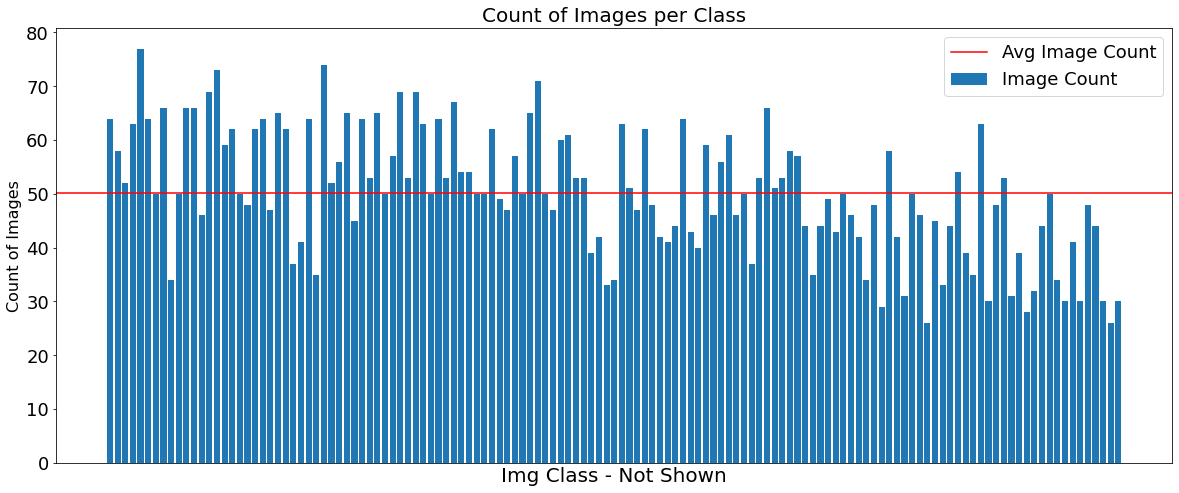

In [4]:
plt.figure(figsize = (20,8))
plt.bar(list(class_file_count.keys()),class_file_count.values(), label = 'Image Count')
plt.axhline(np.average(list(class_file_count.values())), label = 'Avg Image Count', color = 'r')
plt.xticks([])
plt.yticks( fontsize = 18)
plt.legend(loc = 'upper right', fontsize = 18)
plt.title('Count of Images per Class', fontsize = 20)
plt.xlabel('Img Class - Not Shown', fontsize=20)
plt.ylabel('Count of Images', fontsize=16);

from the above plot there we can use accuracy as the metric in this project as the class imbalance is negligible.

## Step 1: Human Detector

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.


Number of faces detected: 1


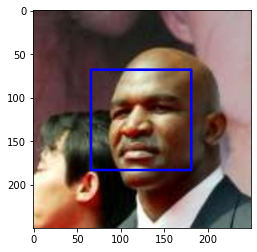

In [5]:

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[randint(1, len(human_files))]) # Pick a random image
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()


Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `opencv_face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns 'True' if face is detected in image stored at img_path
def opencv_face_detector(img_path):
    '''
    Returns True if human faces are detected in an image supplied at img_path. Image recognition based on 
        opencv's haarcascade_frontalface_alt.xml
    
        Parameters:
            img_path (str): Path to the image to be analyzed
        Returns:
            boolean: True if human faces are detected in the image, False if human faces are not detected in the image
    '''
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `opencv_face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

**Answer:** 
<font color = 'blue'>Output of code cell below shows that
- human faces were detected in ca 96% of the first 100 images in human_files and 
- 18% was detected in the first 100 images in dog_files
</font>

In [7]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
# Do NOT modify the code above this line.

In [8]:
## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
### face detection on human_files_short
face_cnt = 0
for img in tqdm(human_files_short):
    if opencv_face_detector(img):
        face_cnt +=1

face_pct = (face_cnt/len(human_files_short)) * 100
print("Human faces were detected in {} percent of the first 100 images human_files".format(face_pct))

### face detection on dog_files_short
face_cnt = 0
for img in tqdm(dog_files_short):
     if opencv_face_detector(img):
            face_cnt += 1

face_pct = (face_cnt/len(dog_files_short)) * 100
print("Human faces were detected in {} percent of the first 100 images dog_files".format(face_pct))

  3%|██▉                                                                                               | 3/100 [00:00<00:03, 24.87it/s]

Human faces were detected in 96.0 percent of the first 100 images human_files


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.92it/s]

Human faces were detected in 18.0 percent of the first 100 images dog_files


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

<font color='blue'>Indeed for this algorithm, I its fair to communicate to the user to provide clear images. However, we can improve our predictions by resulting to the use of deep leaning.
ref: https://www.wired.co.uk/article/facial-recognition-systems-can-identify-you-even-if-your-face-is-blurred
</font>    

---

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.


<font color = 'blue'>In the next set of code cells I create other human face detector algorithms and create a function to test the face detectors, compare the performance and select an optimal human face detector for this project.</font>

<font color = 'blue'> The `2nd face detector` is based on opencv `haarcascade_frontalface_alt_tree.xml`. the xml file is located here:
'haarcascades/haarcascade_frontalface_alt_tree.xml'

The function code is as below
</font>

In [9]:
# returns 'True' if face is detected in image stored at img_path
face_cascade_3 = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt_tree.xml')
def opencv_face_detector2(img_path):
    '''
    Returns True if human faces are detected in an image supplied at img_path. Image recognition based on 
        opencv's haarcascade_frontalface_alt_tree.xml 
    
        Parameters:
            img_path (str): Path to the image to be analyzed
        Returns:
            boolean: True if human faces are detected in the image, False if human faces are not detected in the image
    '''
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade_3.detectMultiScale(gray)
    return len(faces) > 0

<font color = 'blue'> The `3rd face detector` is based on `OpenCV DNN (Deep Neural Network)`. 
    
This network can has two modules based on CAFFEE and TensorFlow.
its coded as below
</font>

In [10]:
def opencv_dnn_caffe_face_detector(img, min_confidence=0.5):
    '''
    Returns True if human faces are detected in an image supplied at img. Image recognition based on 
        opencv's caffe deep neural network
    
        Parameters:
            img (str): Path to the image to be analyzed
            min_confidence (float): cutoff probability for predictions. Minimum probability to filter weak detections
        Returns:
            boolean: True if human faces are detected in the image, False if human faces are not detected in the image
    '''
    
    # load our serialized model from disk    
    modelFile = "OptionalFaceDetector/caffe/res10_300x300_ssd_iter_140000_fp16.caffemodel"
    configFile= "OptionalFaceDetector/caffe/deploy.prototxt"

    # Here we need to read our pre-trained neural net created using Caffe
    net = cv2.dnn.readNetFromCaffe(configFile, modelFile)


    # load the input image and construct an input blob for the image
    # by resizing to a fixed 300x300 pixels and then normalize it

    '''
        Then we load the image , extract the dimensions, and create a blob.
        The dnn.blobFromImage  takes care of pre-processing which includes setting the
        blob  dimensions and normalization.
    '''

    image = cv2.imread("images/suc.jpg")
    image = cv2.resize(image,(int(500),int(500)))
    (h, w) = image.shape[:2]    
    
    
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # pass the blob through the network and obtain the detections and
    # predictions
    #print("[INFO] computing object detections...")
    net.setInput(blob)
    # Runs forward pass to compute outputs of layers listed in outBlobNames.
    detections = net.forward()
    #print("[INFO] completed.")

    
    face_detected = 0 # variable to track count of images with faces detected with confidence greater than min_confidene
    # loop over the detections
    
    for i in range(0, detections.shape[2]):
        # extract the confidence (probability) associated with the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if confidence > min_confidence:
            face_detected = True #log the number of faces detected
            # compute the (x, y)-coordinates of the bounding box for the
            # object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # draw the bounding box of the face along with the associated
            # probability
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY),
                (0, 0, 255), 2)
                # (0,0,255) - red color
            cv2.putText(image, text, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        
            # show the output image
            #cv2.imshow("Output", image)
            #cv2.waitKey(0)

    return face_detected
    
    

In [11]:
def opencv_dnn_tf_face_detector(img, min_confidence=0.5):
    '''
    Returns True if human faces are detected in an image supplied at img. Image recognition based on 
        opencv's tensorflow deep neural network
    
        Parameters:
            img (str): Path to the image to be analyzed
            min_confidence (float): cutoff probability for predictions. Minimum probability to filter weak detections
        Returns:
            boolean: True if human faces are detected in the image, False if human faces are not detected in the image
    '''
    
    
    # load our serialized model from disk
    
    modelFile = "OptionalFaceDetector/tf/opencv_face_detector_uint8.pb"
    configFile= "OptionalFaceDetector/tf/opencv_face_detector.pbtxt"

    # Here we need to read our pre-trained neural net created using Tensorflow
    net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)
   

    # load the input image and construct an input blob for the image
    # by resizing to a fixed 300x300 pixels and then normalize it

    '''
        Then we load the image , extract the dimensions, and create a blob.
        The dnn.blobFromImage  takes care of pre-processing which includes setting the
        blob  dimensions and normalization.
    '''

    image = cv2.imread("images/suc.jpg")
    image = cv2.resize(image,(int(500),int(500)))
    (h, w) = image.shape[:2]    
    
    
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # pass the blob through the network and obtain the detections and
    # predictions
    
    net.setInput(blob)
    # Runs forward pass to compute outputs of layers listed in outBlobNames.
    detections = net.forward()
    
    
    face_detected = 0 # variable to track count of images with faces detected with confidence greater than min_confidene
    # loop over the detections
    
    for i in range(0, detections.shape[2]):
        # extract the confidence (probability) associated with the prediction
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence
        if confidence > min_confidence:
            face_detected = True #log the number of faces detected
            # compute the (x, y)-coordinates of the bounding box for the
            # object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # draw the bounding box of the face along with the associated
            # probability
            text = "{:.2f}%".format(confidence * 100)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.rectangle(image, (startX, startY), (endX, endY),
                (0, 0, 255), 2)
                # (0,0,255) - red color
            cv2.putText(image, text, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        
            # show the output image
            #cv2.imshow("Output", image)
            #cv2.waitKey(0)

    return face_detected
    

<font color = 'blue'>The `4th face detector` is based on dlib as packaged in the face_recognition library. This detector has HOG (Histogram of Oriented Gradients) and CNN based modules.
its coded as below
    
</font>

In [12]:

def dlib_hog_face_detector(img):
    '''
    Returns True if human faces are detected in an image supplied at img. Image recognition based on 
        dlib HOG-based model implemented in the face_recognition library.
    
        Parameters:
            img (str): Path to the image to be analyzed
            
        Returns:
            boolean: True if human faces are detected in the image, False if human faces are not detected in the image
    ''' 
    
    
    # Load the jpg file into a numpy array
    image = face_recognition.load_image_file(img)

    # Find all the faces in the image using the default HOG-based model.
    # This method is fairly accurate, but not as accurate as the CNN model and not GPU accelerated.
        
    face_locations = face_recognition.face_locations(image)
    
    if len(face_locations) > 0:
        return True
    else:
        return False
    

In [13]:

def dlib_cnn_face_detector(img):
    '''
    Returns True if human faces are detected in an image supplied at img. Image recognition based on 
        dlib HOG-based model implemented in the face_recognition library.
    
        Parameters:
            img (str): Path to the image to be analyzed
            
        Returns:
            boolean: True if human faces are detected in the image, False if human faces are not detected in the image
    ''' 
        
    # Load the jpg file into a numpy array
    image = face_recognition.load_image_file(img)

    # Find all the faces in the image using a pre-trained convolutional neural network.
    # This method is more accurate than the default HOG model, but it's slower
    # unless you have an nvidia GPU and dlib compiled with CUDA extensions. But if you do,
    # this will use GPU acceleration and perform well.
        
    face_locations = face_recognition.face_locations(image, number_of_times_to_upsample=0, model="cnn")

    if len(face_locations) > 0:
        return True
    else:
        return False
    

#### <font color = 'blue'>Assess and compare the performance of all the human face detector algorithms and select the optimal algorithim for this project.</font>

In [14]:

human_detector_list = [opencv_face_detector, opencv_face_detector2, opencv_dnn_caffe_face_detector, \
                       opencv_dnn_tf_face_detector, dlib_hog_face_detector, dlib_cnn_face_detector ]
output = dict()
perc_face_human_file = []
perc_face_dog_file = []
time_human_file = []
time_dog_file = []

def face_detector_test(detector):
    # Do NOT modify the code above this line.

    
    for detector in human_detector_list:
    
        ## TODO: Test the performance of the face_detector algorithm 
        ## on the images in human_files_short and dog_files_short.
        ### face detection on human_files_short
        face_cnt = 0
        start_time  = time.time()
        for img in tqdm(human_files_short):
            if detector(img):
                face_cnt +=1

        face_pct = (face_cnt/len(human_files_short)) * 100
        end_time = time.time()
        elasp_time = end_time - start_time
        perc_face_human_file.append(face_pct)
        time_human_file.append(elasp_time)


        ### face detection on dog_files_short
        face_cnt = 0
        start_time  = time.time()
        for img in tqdm(dog_files_short):
             if detector(img):
                    face_cnt += 1

        face_pct = (face_cnt/len(dog_files_short)) * 100
        end_time = time.time()
        elasp_time = end_time - start_time
        perc_face_dog_file.append(face_pct)
        time_dog_file.append(elasp_time)   

    
    output['detector'] = [f.__name__ for f in human_detector_list]
    output['face_human_file'] = perc_face_human_file
    output['face_dog_file'] = perc_face_dog_file
    output['time_human_file'] = time_human_file
    output['time_dog_file'] = time_dog_file
    
    return output



In [15]:
output = face_detector_test(human_detector_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.00it/s]


In [16]:
# plot the result of the test/comparison

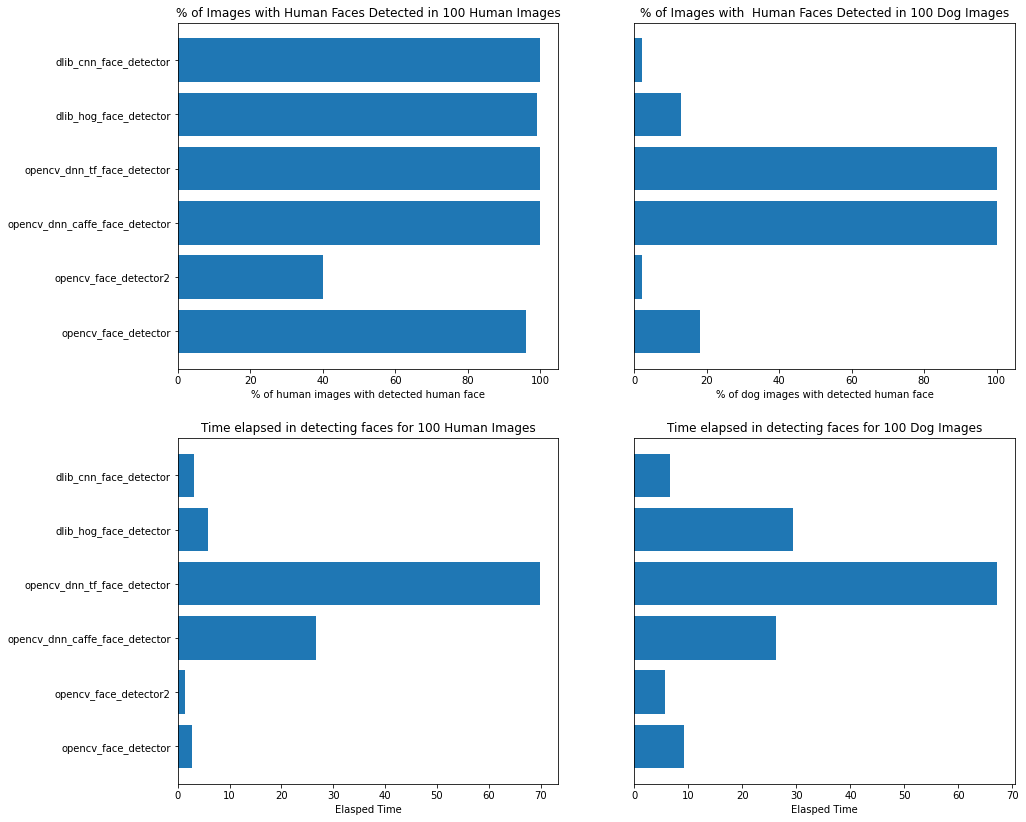

In [17]:
plt.figure(figsize = (15,14))

plt.subplot(2,2,1)
plt.title('% of Images with Human Faces Detected in {} Human Images'.format(len(human_files_short)))
plt.barh(output['detector'],output['face_human_file'])
plt.xlabel('% of human images with detected human face')

plt.subplot(2,2,2)
plt.title('% of Images with  Human Faces Detected in {} Dog Images'.format(len(dog_files_short)))
plt.barh(output['detector'],output['face_dog_file'])
plt.xlabel('% of dog images with detected human face')
plt.yticks([])

plt.subplot(2,2,3)
plt.title('Time elapsed in detecting faces for {} Human Images'.format(len(human_files_short)))
plt.barh(output['detector'],output['time_human_file'])
plt.xlabel('Elasped Time')

plt.subplot(2,2,4)
plt.title('Time elapsed in detecting faces for {} Dog Images'.format(len(dog_files_short)))
plt.barh(output['detector'],output['time_dog_file'])
plt.xlabel('Elasped Time')
plt.yticks([]);


<font color = 'blue'> **Based on the above plots the `dlib_cnn_face_dectector` is selected as the optimal human face detection algorithm**

[ref dlib installation here:](https://medium.com/analytics-vidhya/how-to-install-dlib-library-for-python-in-windows-10-57348ba1117f)
and this link for info on [Face recognition:](https://face-recognition.readthedocs.io/en/latest/readme.html)
</font>

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [VGG-16](https://pytorch.org/hub/pytorch_vision_vgg/) model to detect dogs in images.  Our first line of code downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained VGG16 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

### Obtain Pre_trained VGG-16 Model

In [18]:

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

### Making Predictions with a Pre-trained Model

In [19]:

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path (img_path)
    
    Parameters:
        img_path (string): path to an image
        
    Returns:
        pred(integer): Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    trfrm = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), normalize])
    img_buffer = Image.open(img_path)
    img_buffer = trfrm(img_buffer)
    img = img_buffer.unsqueeze_(0)
    if use_cuda:
        img = img.cuda()
    pred = VGG16(img)
    pred = pred.cpu()
    pred = pred.detach().numpy()
    
    pred = pred.argmax()    
    
    return pred # predicted class index

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained vgg16 model, we need only check if the `vgg16_predict' function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).


In [20]:

def dog_detector(img_path):
    '''
    returns "True" if a dog is detected in the image stored at img_path
        
        Parameters:
        img_path (string): path to an image
        
    Returns:
        response(boolean): True if dog detected, False otherwise.    
    '''
    
    ## TODO: Complete the function.
    img_class = VGG16_predict(img_path)
    
    if img_class >= 151 and img_class <= 268:
        response = True
    else:
        response = False
    
    return response

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
<font color = 'blue'>Output of code cell below shows that
- Dog faces were detected in ca 0% of the first 100 images in human_files and 
- Dog faces were detected in ca 94% of the first 100 images in dog_files
</font>

In [21]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

### face detection on human_files_short
dog_cnt = 0
for img in tqdm(human_files_short):    
    if dog_detector(img):
        dog_cnt += 1

dog_pct = (dog_cnt/len(human_files_short)) * 100
print("Dog faces were detected in {} percent of the first 100 images human_files".format(dog_pct))

### face detection on dog_files_short
dog_cnt = 0
for img in tqdm(dog_files_short):    
    if dog_detector(img):
        dog_cnt += 1

dog_pct = (dog_cnt/len(dog_files_short)) * 100
print("Dog faces were detected in {} percent of the first 100 images dog_files".format(dog_pct))

  3%|██▉                                                                                               | 3/100 [00:00<00:03, 25.65it/s]

Dog faces were detected in 0.0 percent of the first 100 images human_files


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.48it/s]

Dog faces were detected in 93.0 percent of the first 100 images dog_files


In [22]:
# torch.cuda.empty_cache()

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

<font color = 'blue'>Below I  write separate data loaders for the training, validation, and test datasets of dog images (located at dog_images/train, dog_images/valid, and dog_images/test, respectively). I have also applied some augmentation/transforms to the training data to improve the performance of the model.
</font>

In [23]:
# define data directories

data_dir = "data/dog_images/"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Transformation setup to be applied

train_data_transforms = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(10),                                     
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

valid_data_transforms = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),                                    
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])


test_data_transforms = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

transforms_dict  = {'train': train_data_transforms, 'valid': valid_data_transforms, 'test': test_data_transforms}

# Define dataloader parameters
batch_size = 20
num_workers = 0

# Train dataloaders
train_data = datasets.ImageFolder(train_dir, transform = transforms_dict['train'])
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)

# Validation dataloaders
valid_data = datasets.ImageFolder(valid_dir, transform = transforms_dict['valid'])
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)    
    
# Test dataloaders
test_data = datasets.ImageFolder(test_dir, transform = transforms_dict['test'])
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)

# Capture the data and loaders in dictionaries for easy manupulation in subsequent codes.
imagedata_scratch = {'train': train_data, 'valid': valid_data, 'test': test_data}
loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

classes = imagedata_scratch['train'].classes

In [24]:
#Code block to printout number of images in the train, valid and test data loader
print("There are {} images in the train_loader".format(len(imagedata_scratch['train'])))
print("There are {} images in the valid_loader".format(len(imagedata_scratch['valid'])))
print("There are {} images in the test_loader".format(len(imagedata_scratch['test'])))
print("\nThere are {} dog classes in train_data".format(len(imagedata_scratch['train'].classes)))

There are 6680 images in the train_loader
There are 835 images in the valid_loader
There are 836 images in the test_loader

There are 133 dog classes in train_data


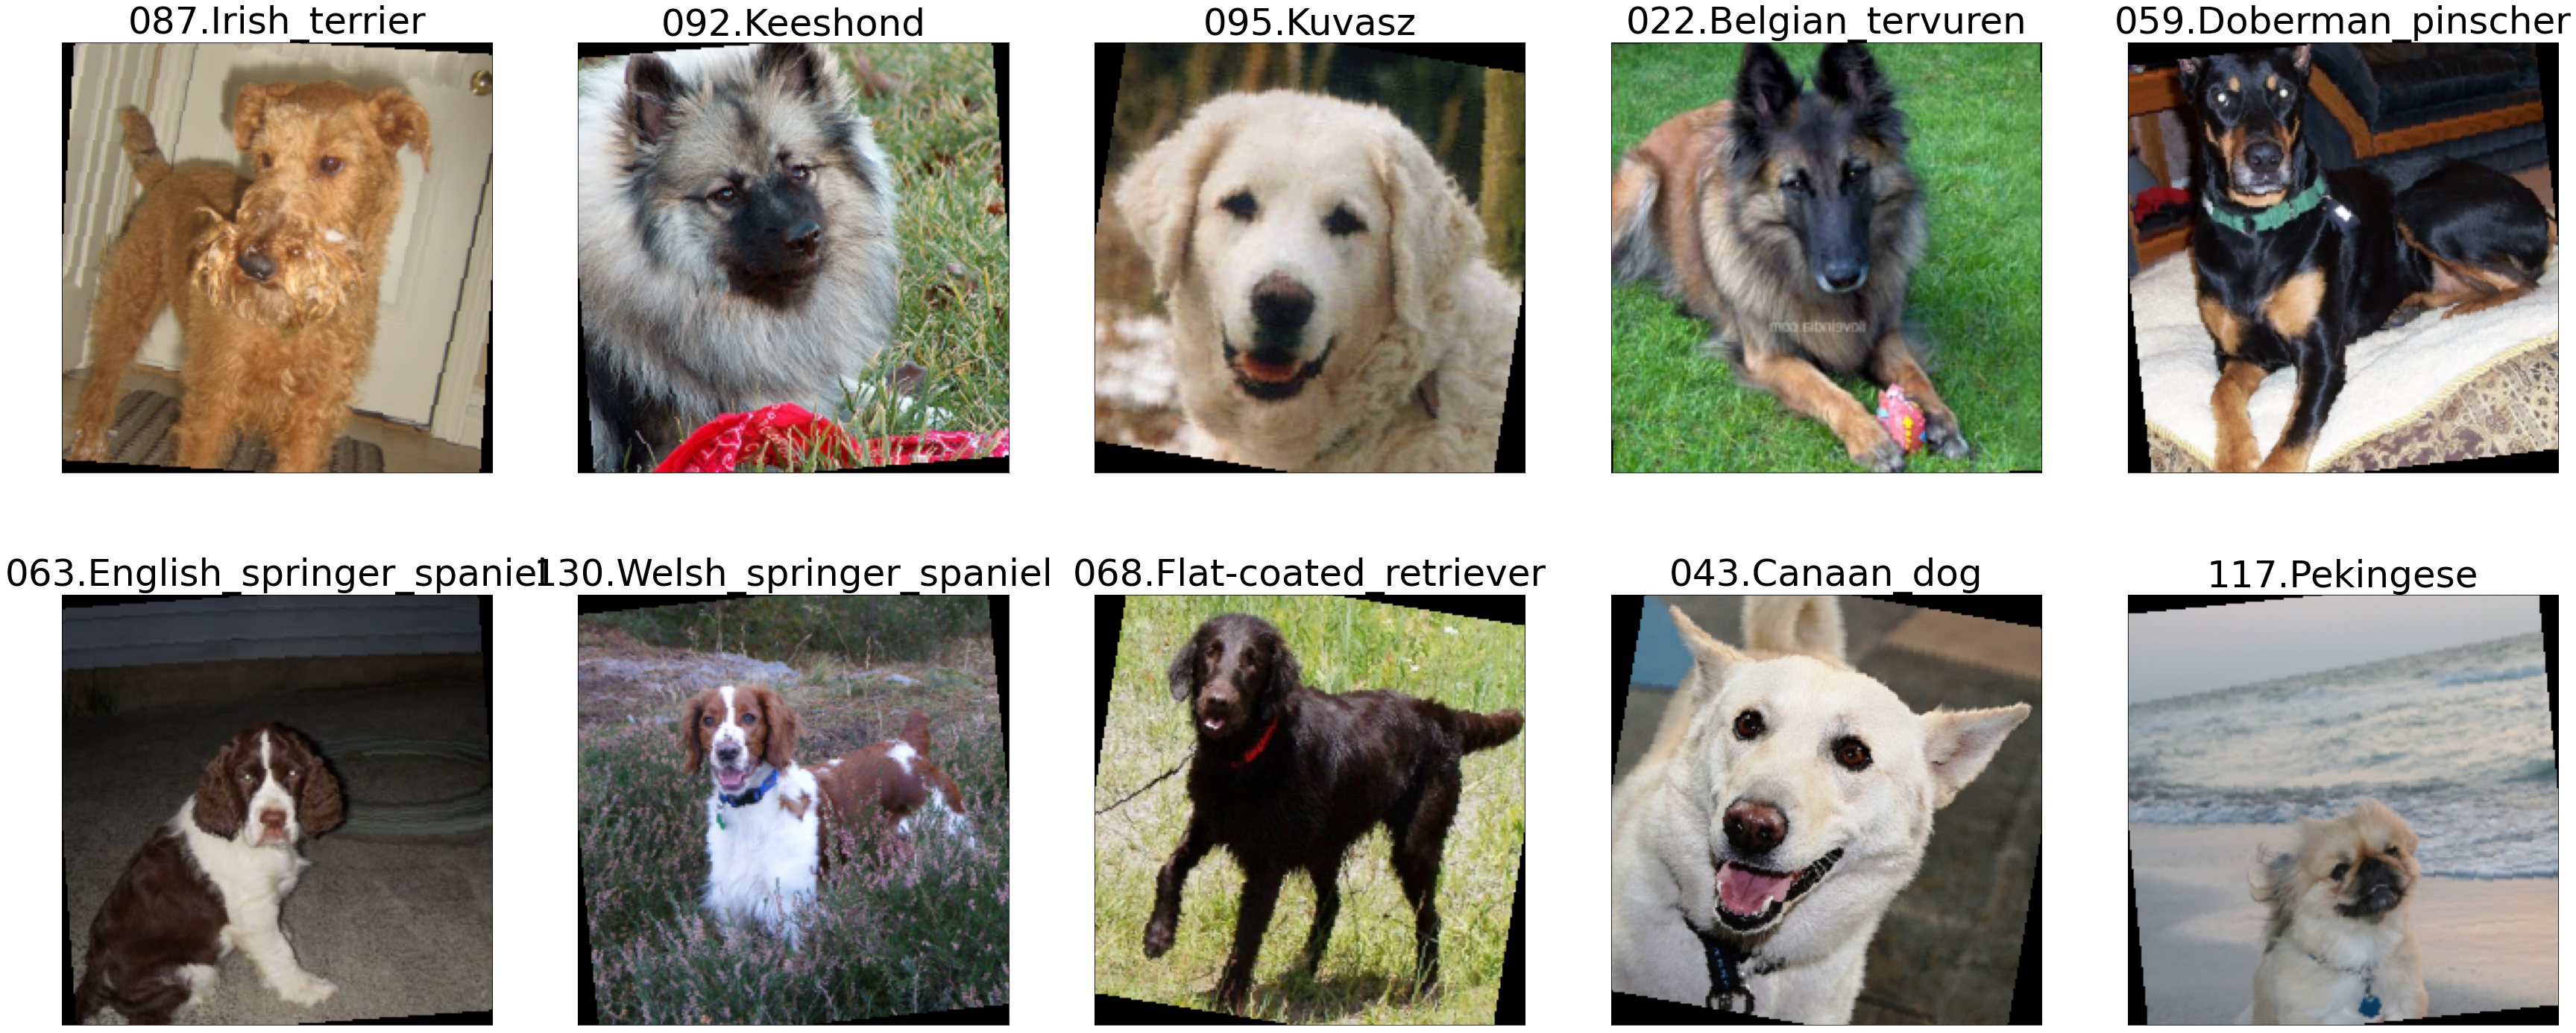

In [25]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(60, 25))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    #plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    #print(images[idx].path)
    pltData = np.transpose(images[idx], (1, 2, 0))
    pltData = pltData * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) #reverse normalization
    pltData = np.clip(pltData, 0,1)
    plt.imshow(pltData)
    ax.set_title(classes[labels[idx]], fontsize = 50)

## (IMPLEMENTATION) Model Architecture

<font color = 'blue'>Below I create a custom CNN classifier for the dog breed.</font>


In [26]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    '''
    class to define custom CNN from scratch
    
    '''
    
    
    def __init__(self):
        '''
        class init function
        '''
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        ### Conv Layers
        ### input shape to this layer: 224 X 224 X 3
        self.conv1 = nn.Conv2d(3, 16, 3, stride =1, padding = 1) # Output shape 224 X 224 X 16
        ### after pooling, shape into conv2 : 112 X 112 X 16
        self.conv2 = nn.Conv2d(16, 32, 3, stride = 1, padding = 1) # Output shape 112 X 112 X 16
        ### after pooling, shape into conv3 : 56 X 56 X 32
        self.conv3 = nn.Conv2d(32, 64, 3, stride = 1, padding = 1) # Output shape 56 X 56 X 64
        ### after pooling, shape into conv4 : 28 X 28 X 64
        self.conv4 = nn.Conv2d(64, 128, 3, stride = 1, padding = 1) # Output shape 28 X 28 X 128
        ### after pooling, shape into conv5 : 14 X 14 X 128
        self.conv5 = nn.Conv2d(128, 256, 3, stride = 1, padding = 1) # Output shape 14 X 14 X 256
        ### shape into flatten : 7 X 7 X 256
        
        ### Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        ### Fully connected layers
        
        self.fc1 = nn.Linear(7 * 7 * 256, 500)        
        self.fc2 = nn.Linear(500, 133)
        
        ### Drop-out
        self.dropout = nn.Dropout(0.25)
        
        ## BatchNormalization 
        self.conv_bn1 = nn.BatchNorm2d(16)
        self.conv_bn2 = nn.BatchNorm2d(32)
        self.conv_bn3 = nn.BatchNorm2d(64)
        self.conv_bn4 = nn.BatchNorm2d(128)
        self.conv_bn5 = nn.BatchNorm2d(256)      
        
        
        
    def forward(self, x):
        '''
        network forward behaviour compilation
        '''
        ## Define forward behavior
        x = F.relu(self.conv1(x)) ### shape 224
        x = self.pool(x) ### Shape 112
        x = self.conv_bn1(x)
        
        x = F.relu(self.conv2(x)) ### shape 112
        x = self.pool(x) ### Shape 56
        x = self.conv_bn2(x)
        
        x = F.relu(self.conv3(x)) ### Shape 56
        x = self.pool(x) ### Shape 28
        x = self.conv_bn3(x)
        
        
        x = F.relu(self.conv4(x)) ### shape 28
        x = self.pool(x) ### outshape 14
        x = self.conv_bn4(x)
        
        
        x = F.relu(self.conv5(x)) ### outShape 14
        x = self.pool(x) ### outShape 7
        x = self.conv_bn5(x)
        
        
        ### Flatten image input
        x = x.view(-1, 7 * 7 * 256)
        
        ### add dropout
        x = self.dropout(x)
        
        ### add fully connected layer
        x = F.relu(self.fc1(x))
        
        ### add dropout
        x = self.dropout(x)
        
        ### add fully connected layer
        x = F.relu(self.fc2(x))
        
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [27]:
model_scratch

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, tr

### (IMPLEMENTATION) Specify Loss Function and Optimizer

<font color = 'blue' >Below I specify the loss function and optimizer. </font>

In [28]:
# loss function
criterion_scratch = nn.CrossEntropyLoss()

# optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(),lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

<font color = 'blue'>Train and validate your model in the code cell below. Save the final model parameters at filepath 'saved_models/model_scratch.pt'. </font>

In [29]:

n_epochs = 30 
vlos = []
tlos = []
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''
    model training function
    
    Parameters:
        n_epochs (int) : number of epochs
        loaders: list of torch.utils.data.DataLoader object
        model: torch model
        optimizer: torch optimizer object
        criterion: torch loss function
        use_cuda (boolean),: True - use GPU, False - use CPU
        save_path (str)    : Path to save model with  best validation accuracy.
        
    returns:
        Trained model
    
    '''
    
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            ### clear the gradients of all optimized variables
            optimizer.zero_grad()
            
            ### forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            ### calculate the batch loss
            loss = criterion(output, target)
            
            ### backward pass: Compute gradient of the loss with respect to model parameters
            loss.backward()
            
            ### perform a single opttimization step (parameter update)
            optimizer.step()
            
            ### Update training loss
            train_loss += loss.item()*data.size(0)
            
            ### average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            ## forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            
            # Calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss
            valid_loss += loss.item() * data.size(0)
            
        ### Calculate/Update average losses
        valid_loss = valid_loss +  ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        tlos.append(train_loss)
        vlos.append(valid_loss)     
        
        
        
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased from ({:.6f} to {:.6f}) .   Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model



In [30]:
# train the model
model_scratch = train(10, loaders_scratch, model_scratch, 
                      optimizer_scratch, criterion_scratch, use_cuda, 'saved_models/model_scratch.pt')


Epoch: 1 	Training Loss: 15268.779297 	Validation Loss: 3608.538818
Validation loss decreased from (inf to 3608.538818) .   Saving model ...
Epoch: 2 	Training Loss: 13741.890625 	Validation Loss: 3396.665039
Validation loss decreased from (3608.538818 to 3396.665039) .   Saving model ...
Epoch: 3 	Training Loss: 12545.084961 	Validation Loss: 3187.065674
Validation loss decreased from (3396.665039 to 3187.065674) .   Saving model ...
Epoch: 4 	Training Loss: 11480.525391 	Validation Loss: 3091.427979
Validation loss decreased from (3187.065674 to 3091.427979) .   Saving model ...
Epoch: 5 	Training Loss: 10512.092773 	Validation Loss: 2985.886719
Validation loss decreased from (3091.427979 to 2985.886719) .   Saving model ...
Epoch: 6 	Training Loss: 9615.669922 	Validation Loss: 3014.722168
Epoch: 7 	Training Loss: 8711.572266 	Validation Loss: 2924.440430
Validation loss decreased from (2985.886719 to 2924.440430) .   Saving model ...
Epoch: 8 	Training Loss: 7895.794922 	Validation

In [31]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('saved_models/model_scratch.pt'))

<All keys matched successfully>

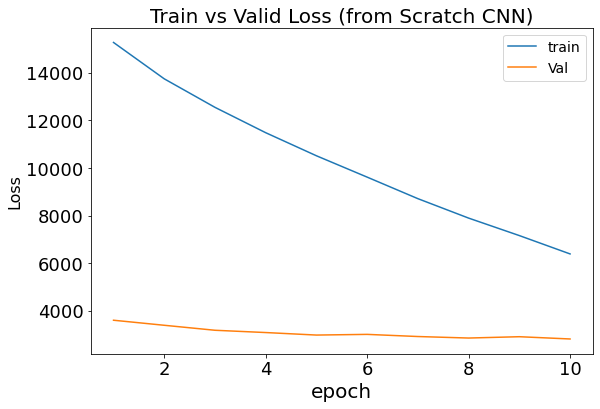

In [32]:
# Plot Training and Validation losess
x = list(np.arange(1,11))
plt.figure(figsize = (9,6))
plt.plot(x, tlos, label = 'train')
plt.plot(x, vlos, label = 'Val')
plt.xticks( fontsize = 18)
plt.yticks( fontsize = 18)
plt.legend(loc = 'upper right', fontsize = 14)
plt.title('Train vs Valid Loss (from Scratch CNN)', fontsize = 20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('Loss', fontsize=16);

In [33]:
#reset vlos and tlos
vlos.clear()
tlos.clear()


### (IMPLEMENTATION) Test the Model

In [34]:
def test(loaders, model, criterion, use_cuda):
    '''
    Funtion to test the model
    
    Parameters:
    
        loaders: list of torch.utils.data.DataLoader object
        model: torch model
        criterion: torch loss function
        use_cuda (boolean),: True - use GPU, False - use CPU
        
    Returns:
        prints out the result of the test in terms of accuracy.
    
    '''
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))



In [35]:
# call test function    
# test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.395079


Test Accuracy: 20% (172/836)


## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images. Your CNN must attain at least 60% accuracy on the test set.

In this section, I apply transfer leaning using 
- [resnet50](https://pytorch.org/hub/nvidia_deeplearningexamples_resnet50/)


## (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

I will use the data loaders created early. 


## (IMPLEMENTATION) Model Architecture
Use transfer learning to create a CNN to classify dog breed. Use the code cell below, and save your initialized model as the variable model_transfer.

In [36]:
import torchvision.models as models
import torch.nn as nn

### Load pretrained model from pytorch. 
#transfer_learning_model = models.vgg16(pretrained = True) # line for use of VGG16 commented out 
#transfer_learning_model = models.inception_v3(pretrained = True)

transfer_learning_model = models.resnet50(pretrained = True)

#transfer_learning_model = models.vgg19(pretrained = True)

print(transfer_learning_model) # explore model architecture  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
### freeze training for all "features" layers 20

#for param in transfer_learning_model.features.parameters():
#    param.requires_grad = True


#for resnet50
for param in transfer_learning_model.parameters():
    param.requires_grad = False
for param in transfer_learning_model.fc.parameters():
    param.requires_grad = True


#for param in transfer_learning_model.classifier[6].parameters():
#    param.requires_grad = True



In [38]:
# Replace final layer to output 133 classes corresponding to the dog breed classes
# n_inputs = vgg16.classifier[6].in_features # line for VGG16
n_inputs = transfer_learning_model.fc.in_features # for resnet50

#n_inputs = transfer_learning_model.classifier[6].in_features # for VGG19

#vgg16.classifier[6] = last_layer

last_layer = nn.Linear(n_inputs, len(classes), bias = True)
#transfer_learning_model.classifier[6] = last_layer # for VGG19

#transfer_learning_model.classifier[6] = last_layer

transfer_learning_model.fc = last_layer # for resnet50


In [39]:
#print model architecture to check that all is well
#print(transfer_learning_model.classifier[6]) # VGG16 and 19
print(transfer_learning_model.fc) #for resnet


Linear(in_features=2048, out_features=133, bias=True)


In [40]:
torch.cuda.empty_cache()

In [41]:
### move model to GPU if available

if use_cuda:
    transfer_learning_model = transfer_learning_model.cuda()

**Question 5**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step. Describe why you think the architecture is suitable for the current problem.

**Answer:**
<font color = 'blue'>Opted to use the inception model. Inpported the model, froze the features layers and changed the last fully connected layer of the classifer to suit the number of classes for this classification problem.
</font>

## (IMPLEMENTATION) Specify Loss Function and Optimizer
Use the next code cell to specify a loss function and optimizer. Save the chosen loss function as criterion_transfer, and the optimizer as optimizer_transfer below.

In [42]:
criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.SGD(vgg16.classifier.parameters(), lr = 0.001) for VGG16
optimizer_transfer = optim.SGD(transfer_learning_model.parameters(), lr = 0.001)

## (IMPLEMENTATION) Train and Validate the Model
Train and validate your model in the code cell below. Save the final model parameters at filepath `'saved_models/transfer_learning_model.pt'`.

In [43]:
# train the model
#model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')
transfer_learning_model = train(30, loaders_scratch, transfer_learning_model, optimizer_transfer, criterion_transfer, use_cuda, 'saved_models/transfer_learning_model.pt')

Epoch: 1 	Training Loss: 15808.342773 	Validation Loss: 3770.212158
Validation loss decreased from (inf to 3770.212158) .   Saving model ...
Epoch: 2 	Training Loss: 14952.516602 	Validation Loss: 3545.592041
Validation loss decreased from (3770.212158 to 3545.592041) .   Saving model ...
Epoch: 3 	Training Loss: 14152.215820 	Validation Loss: 3325.832275
Validation loss decreased from (3545.592041 to 3325.832275) .   Saving model ...
Epoch: 4 	Training Loss: 13425.712891 	Validation Loss: 3136.481689
Validation loss decreased from (3325.832275 to 3136.481689) .   Saving model ...
Epoch: 5 	Training Loss: 12694.814453 	Validation Loss: 2950.731445
Validation loss decreased from (3136.481689 to 2950.731445) .   Saving model ...
Epoch: 6 	Training Loss: 12018.498047 	Validation Loss: 2773.926025
Validation loss decreased from (2950.731445 to 2773.926025) .   Saving model ...
Epoch: 7 	Training Loss: 11353.831055 	Validation Loss: 2591.068848
Validation loss decreased from (2773.926025 to

In [44]:
# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

transfer_learning_model.load_state_dict(torch.load('saved_models/transfer_learning_model.pt'))

<All keys matched successfully>

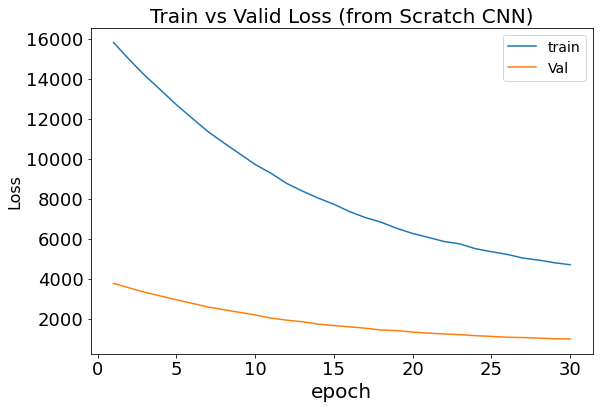

In [45]:
# Plot Training and Validation losess
x = list(np.arange(1,31))
plt.figure(figsize = (9,6))
plt.plot(x, tlos, label = 'train')
plt.plot(x, vlos, label = 'Val')
plt.xticks( fontsize = 18)
plt.yticks( fontsize = 18)
plt.legend(loc = 'upper right', fontsize = 14)
plt.title('Train vs Valid Loss (transfer learning CNN)', fontsize = 20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('Loss', fontsize=16);

## (IMPLEMENTATION) Test the Model
Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy. Ensure that your test accuracy is greater than 60%.

In [46]:
# test the model
test(loaders_scratch, transfer_learning_model, criterion_transfer, use_cuda)

Test Loss: 1.206606


Test Accuracy: 81% (684/836)


## (IMPLEMENTATION) Predict Dog Breed with the Model
Write a function that takes an image path as input and returns the dog breed (Affenpinscher, Afghan hound, etc) that is predicted by your model.

In [47]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
# class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

class_names = [dclass[4:].replace("_"," ") for dclass in classes]
print(class_names)
print(len(class_names))

['Affenpinscher', 'Afghan hound', 'Airedale terrier', 'Akita', 'Alaskan malamute', 'American eskimo dog', 'American foxhound', 'American staffordshire terrier', 'American water spaniel', 'Anatolian shepherd dog', 'Australian cattle dog', 'Australian shepherd', 'Australian terrier', 'Basenji', 'Basset hound', 'Beagle', 'Bearded collie', 'Beauceron', 'Bedlington terrier', 'Belgian malinois', 'Belgian sheepdog', 'Belgian tervuren', 'Bernese mountain dog', 'Bichon frise', 'Black and tan coonhound', 'Black russian terrier', 'Bloodhound', 'Bluetick coonhound', 'Border collie', 'Border terrier', 'Borzoi', 'Boston terrier', 'Bouvier des flandres', 'Boxer', 'Boykin spaniel', 'Briard', 'Brittany', 'Brussels griffon', 'Bull terrier', 'Bulldog', 'Bullmastiff', 'Cairn terrier', 'Canaan dog', 'Cane corso', 'Cardigan welsh corgi', 'Cavalier king charles spaniel', 'Chesapeake bay retriever', 'Chihuahua', 'Chinese crested', 'Chinese shar-pei', 'Chow chow', 'Clumber spaniel', 'Cocker spaniel', 'Collie',

In [48]:
def predict_breed_transfer(img_path):
    '''
    loads the image and return the predicted breed
    
    Parameters:
        img_path(str): Path to image file
    returns:
        string: dog breed
    
    '''
    
    img_pil = Image.open(img_path)
    img_tensor = transforms_dict['test'](img_pil)
    img = img_tensor.unsqueeze_(0)
    if use_cuda:
        img = img.cuda()
    pred = transfer_learning_model(img)
    
    breed_id = pred.argmax()
    breed = class_names[breed_id]    
    return breed

In [49]:
#Testing...
predict_breed_transfer("./data/dog_images/test/115.Papillon/Papillon_07454.jpg")

'Papillon'

<a id='step6'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `optimal face_detector` and `dog_detector` functions developed earlier.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [50]:
## This block of code accepths a list of files and test them against dog_dector, face_detector and the CNN algorithm
from PIL import Image as PilImage


def run_app(img_path):
    '''
    checks if the image provided is a human, dog, or otherwise. If its a dog, it predicts the dog breed, if its a human,
    it predicts the closest resembling dog, otherwise it states that the image is neither a dog or human
    
    Parameters:
        img_path: Path to the image
        
    '''
    images = []
    
    for x in img_path:
        try:
            images.append(PilImage.open(x))
        except:
            print("{} is not recognized as a valid image".format(x))
            img_path.remove(x)
        
        
        
    columns = 3
    width = 20
    height = 8
    max_images = 20
    label_font_size = 18
    
    if not images:
        print("No images to display.")
        return
    
    if len(images) > max_images:
        print(f"showing {max_images} images of {len(images)}:")
        images = images[0:max_images]
    
    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize = (width, height))
    
    for i, image in enumerate(images):        
        plt.subplot(len(images) / columns + 1, columns, i + 1, xticks = [], yticks = [])
        plt.imshow(image)
        
        if dog_detector(img_path[i]):
            breed = predict_breed_transfer(img_path[i])
            plt.title("Likely a dog of breed:\n " + breed, fontsize = label_font_size)
        elif dlib_cnn_face_detector(img_path[i]): # Use optimal face dector
            breed = predict_breed_transfer(img_path[i])
            plt.title("Likely a human, \nresembles a: " + breed + " dog breed", fontsize = label_font_size)
        else:
            plt.title("Neither dog or human", fontsize = label_font_size)
            

In [51]:
### Code block adopted from: edusecrets.com/lesson-02-creating-a-file-select-button-in-jupyter-notebook/
from ipywidgets import Button
from tkinter import Tk, filedialog
from IPython.display import clear_output, display

def select_files():
    '''
    Helper function to display a file selection dialog
    
    Returns: selected files
    '''
    
    clear_output()
    root = Tk()
    root.withdraw() # Hide the main window
    root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
    files = filedialog.askopenfilename(multiple=True) # List of selected files will be set button's file attribute.
    files = list(files)
    return files
     

---
<a id='step7'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
<font color = 'blue'>
Output is better. 

- CNN was trained for only 10 epochs, may be increasing this may help in imporving the consistency no matter the subject orientation in the image
- add more augumentation to create more variety in the training dataset.
- explore the application and performance of other preTrained CNN architechture
</font>

<ipython-input-50-e9cf9e679b5e>:43: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(len(images) / columns + 1, columns, i + 1, xticks = [], yticks = [])


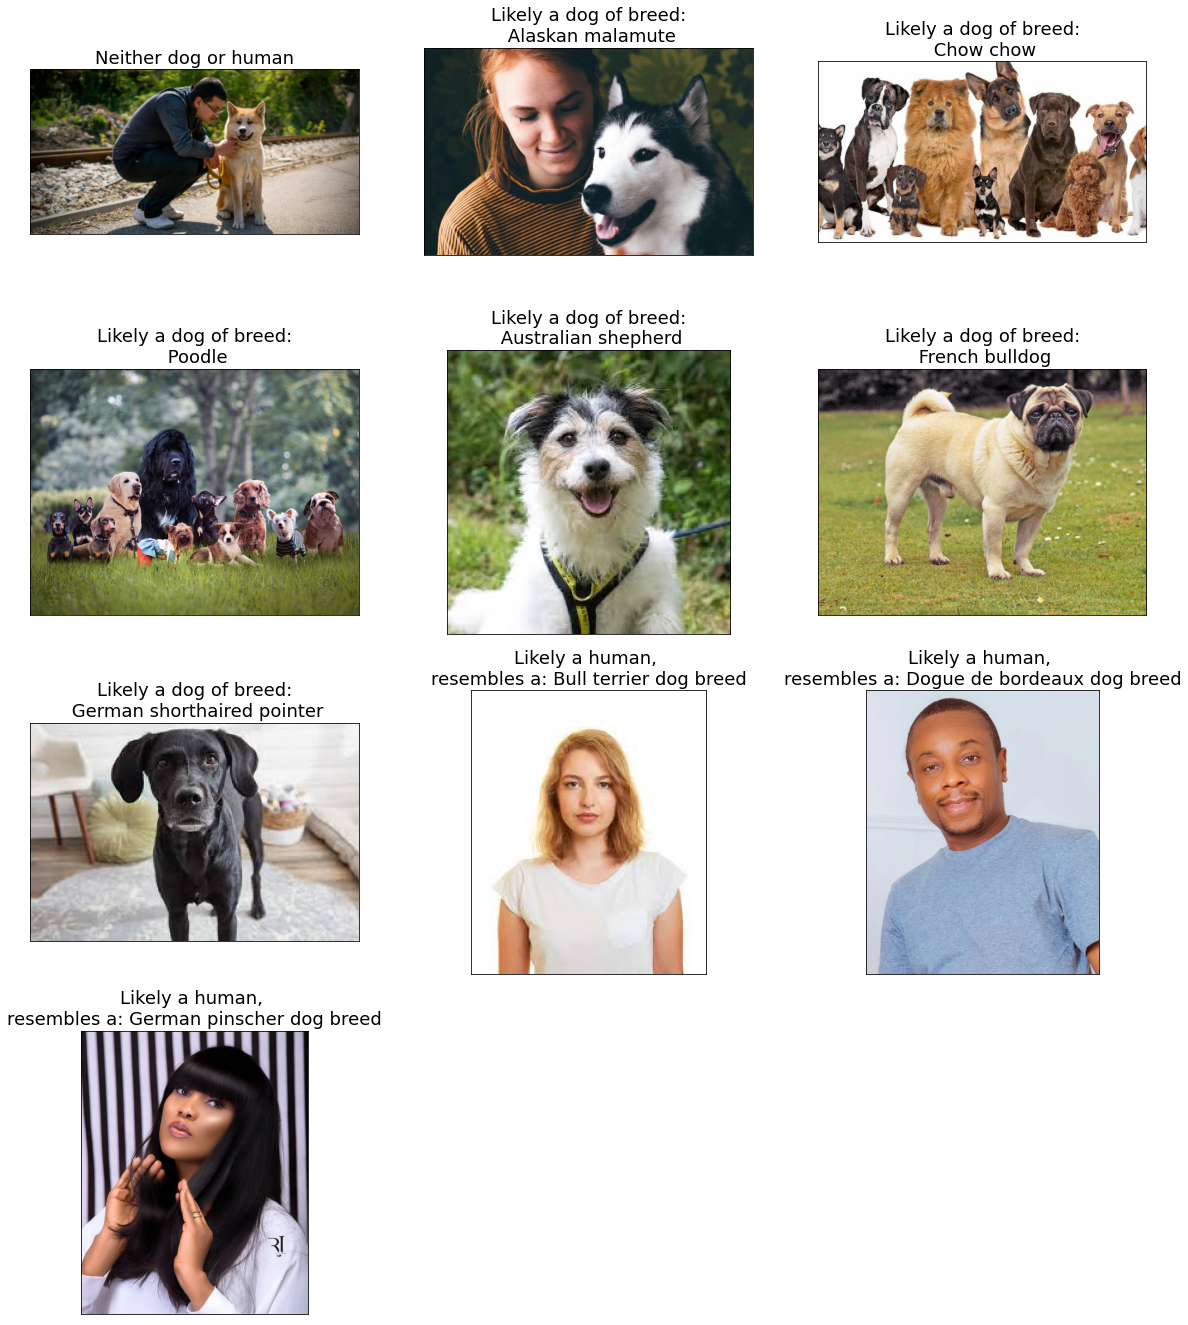

In [52]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

imgfiles = select_files()    
run_app(imgfiles)

#for file in np.hstack((human_files[:3], dog_files[:3])):
#    run_app(file)